## Predictor variable selection ## 

#### forward selection (Eforymson 1966; Draper and Smith 1966) ####

Iteratively build up a model by adding one predictor variable at a time, starting one with no predictors.

Run the following 3 steps until you run out of predictors:
1. For each unused predictor, add it to the model to form a candidate model.
2. Tune all of the candidate models.
3. Update the model to be the candidate model with the highest cross-validation accuracy.

Select the model that provides the best trade-off between accuracy and simplicity.

### set-up ###

In [159]:
# loading packages
library(repr)
library(tidyverse)
library(tidymodels)
# library(themis)
set.seed(31)

In [160]:
# loading data
stroke <- read_csv("data/stroke-data.csv")
colnames(stroke)

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)



[1] "id"                "gender"            "age"              
 [4] "hypertension"      "heart_disease"     "ever_married"     
 [7] "work_type"         "Residence_type"    "avg_glucose_level"
[10] "bmi"               "smoking_status"    "stroke"

In [161]:
# cleaning and wrangling
# stroke_clean <- stroke %>%
#     select(gender, age, hypertension, heart_disease, avg_glucose_level, bmi, smoking_status, stroke) %>%
#     mutate(gender = as_factor(gender), 
#            bmi = as.numeric(bmi),
#            smoking_status = as_factor(smoking_status),
#            stroke = as_factor(stroke)) %>%
#     filter(gender != "Other") #Other was removed as there was only one occurrence in the dataset

# prep and bake data with upsampling, then use it with everything
# gonna overfit data, data leakage
stroke_clean <- stroke %>%
    select(age, hypertension, heart_disease, avg_glucose_level, bmi, stroke) %>%
    mutate(stroke = as_factor(stroke),
           bmi = as.numeric(bmi)) 

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [162]:
head(stroke_clean)

age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,0,1,228.69,36.6,1
61,0,0,202.21,NA,1
80,0,1,105.92,32.5,1
49,0,0,171.23,34.4,1
79,1,0,174.12,24.0,1
81,0,0,186.21,29.0,1


#### Split data

In [192]:
stroke_split <- initial_split(stroke_clean, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

### Downsampling

In [193]:
ds_recipe <- recipe(stroke ~ ., data = stroke_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_downsample(stroke, under_ratio = 1, skip = FALSE) %>%
    prep()
dsampled_stroke <- bake(ds_recipe, stroke_train)

head(dsampled_stroke)

age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9106651,-0.3360366,-0.2413295,-0.6663583,1.2327400,0
1.0428475,-0.3360366,-0.2413295,-0.8342994,-0.3405529,0
-1.5126789,-0.3360366,-0.2413295,-0.6495642,-1.4156363,0
0.1616315,-0.3360366,-0.2413295,-0.1318196,0.3149858,0
-1.4686181,-0.3360366,-0.2413295,-0.6486803,-1.7040733,0
-0.5874021,-0.3360366,-0.2413295,-0.3324649,NA,0


In [194]:
ratio_stats_dsampled <- dsampled_stroke %>%
  group_by(stroke) %>%
  summarize(n = n())

ratio_stats_dsampled

`summarise()` ungrouping output (override with `.groups` argument)



stroke,n
<fct>,<int>
0,188
1,188


### Forward Selection

In [195]:
# DOWNSAMPLE here!!!

In [196]:
stroke_subset <- dsampled_stroke %>%
    filter(!is.na(bmi))
names <- colnames(dsampled_stroke %>% select(-stroke)) %>% sort()
names

[1] "age"               "avg_glucose_level" "bmi"              
[4] "heart_disease"     "hypertension"

In [197]:
example_formula <- paste("stroke", "~", paste(names, collapse="+"))
example_formula

[1] "stroke ~ age+avg_glucose_level+bmi+heart_disease+hypertension"

In [198]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


In [199]:
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
stroke_vfold <- vfold_cv(stroke_subset, v = 5, strata = stroke)

gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 2))

In [200]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

In [136]:
set.seed(31)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    print("start")
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        print(model_string)
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

#         !!! how can i repeat the below step more to make it more accurate?
        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = gridvals) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    print("unlist")
    print(unlist(accs))
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

[1] "start"
[1] "stroke ~ age"
[1] "stroke ~ avg_glucose_level"
[1] "stroke ~ bmi"
[1] "stroke ~ heart_disease"
[1] "stroke ~ hypertension"
[1] "unlist"
[1] 0.7507246 0.6463768 0.5449275 0.6231884 0.5449275
[1] "start"
[1] "stroke ~ age+avg_glucose_level"
[1] "stroke ~ age+bmi"
[1] "stroke ~ age+heart_disease"
[1] "stroke ~ age+hypertension"
[1] "unlist"
[1] 0.7478261 0.7420290 0.7565217 0.7536232
[1] "start"
[1] "stroke ~ age+heart_disease+avg_glucose_level"
[1] "stroke ~ age+heart_disease+bmi"
[1] "stroke ~ age+heart_disease+hypertension"
[1] "unlist"
[1] 0.7333333 0.7362319 0.7565217
[1] "start"
[1] "stroke ~ age+heart_disease+hypertension+avg_glucose_level"
[1] "stroke ~ age+heart_disease+hypertension+bmi"
[1] "unlist"
[1] 0.7478261 0.7478261
[1] "start"
[1] "stroke ~ age+heart_disease+hypertension+avg_glucose_level+bmi"
[1] "unlist"
[1] 0.7710145


size,model_string,accuracy
<int>,<chr>,<dbl>
1,stroke ~ age,0.7507246
2,stroke ~ age+heart_disease,0.7565217
3,stroke ~ age+heart_disease+hypertension,0.7565217
4,stroke ~ age+heart_disease+hypertension+avg_glucose_level,0.7478261
5,stroke ~ age+heart_disease+hypertension+avg_glucose_level+bmi,0.7710145


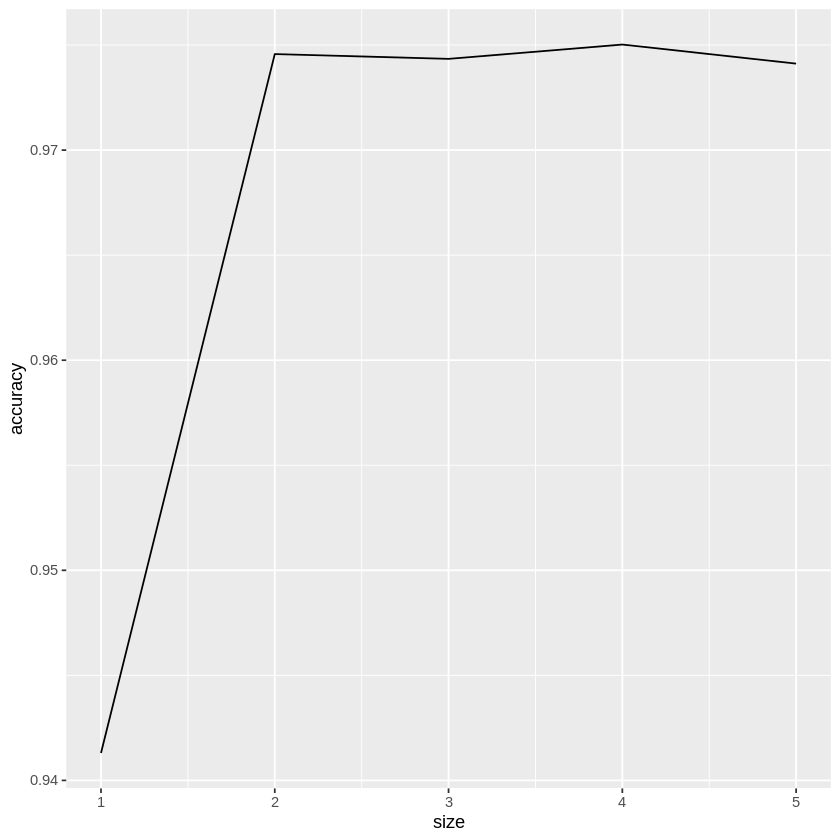

In [165]:
ggplot(accuracies, aes(x=size, y=accuracy)) +
geom_line()

## K-value Selection ##

In [213]:
stroke_recipe <- recipe(stroke ~ avg_glucose_level + age, data = dsampled_stroke) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

In [214]:
stroke_vfold <- vfold_cv(dsampled_stroke, v = 5, strata = stroke)
k_vals <- tibble(neighbors = seq(from = 1, to = 15))

In [215]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

In [216]:
knn_results <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = stroke_vfold, grid = k_vals) %>%
  collect_metrics() 
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6754623,5,0.01500762,Model01
1,roc_auc,binary,0.6754623,5,0.01500762,Model01
2,accuracy,binary,0.6754623,5,0.01500762,Model02
2,roc_auc,binary,0.7470012,5,0.02618414,Model02
3,accuracy,binary,0.7154339,5,0.03250391,Model03
3,roc_auc,binary,0.7749818,5,0.02734958,Model03
4,accuracy,binary,0.7154339,5,0.03250391,Model04
4,roc_auc,binary,0.7945336,5,0.02605824,Model04
5,accuracy,binary,0.7475107,5,0.01968696,Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.7579659,5,0.02347881,Model11
12,accuracy,binary,0.7579659,5,0.02347881,Model12


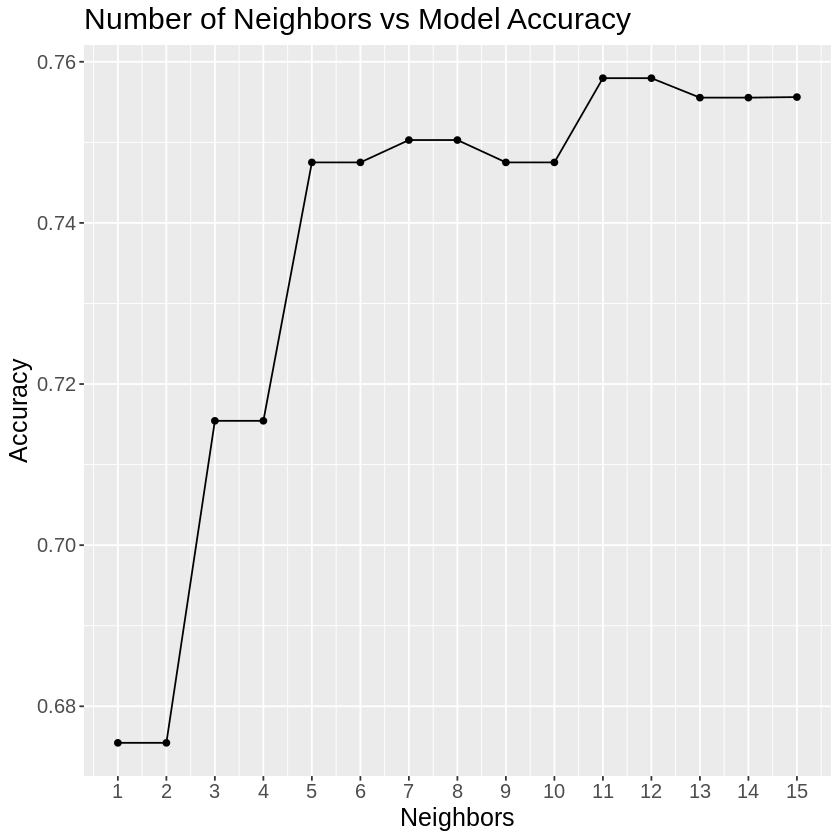

In [218]:
accuracies <- knn_results %>% # Plot accuracies vs neighbours
  filter(.metric == "accuracy")


accuracies_vs_ks <- accuracies %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Number of Neighbors vs Model Accuracy") +
    labs(x="Neighbors", y="Accuracy") +
    theme(text = element_text(size=15)) +
    scale_x_continuous(breaks=c(1:15))

accuracies_vs_ks


optimal_neighbours <- accuracies %>%
  filter(mean == max(mean))
optimal_neighbours

## Model Construction

In [219]:
stroke_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
  set_engine("kknn") %>%
  set_mode("classification")

stroke_fit <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(stroke_spec) %>%
  fit(data = dsampled_stroke)
stroke_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~11, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2553191
Best kernel: rectangular
Best k: 11

## Test Set Prediction

In [221]:
set.seed(31)




stroke_test_predictions <- predict(stroke_fit, stroke_test) %>%
  bind_cols(stroke_test)

stroke_test_predictions

stroke_test_accuracies <- stroke_test_predictions %>%
  metrics(truth = stroke, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

stroke_test_accuracies


stroke_confusion_mat <- stroke_test_predictions %>%
             conf_mat(truth = stroke, estimate = .pred_class)

stroke_confusion_mat

.pred_class,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,80,0,1,105.92,32.5,1
1,81,0,0,186.21,29.0,1
1,78,0,0,58.57,24.2,1
1,81,1,0,80.43,29.7,1
1,78,0,1,219.84,NA,1
1,71,0,0,193.94,22.4,1
1,71,0,0,102.87,27.2,1
1,58,0,0,189.84,NA,1
1,57,1,0,212.08,44.2,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.04776821


          Truth
Prediction    0    1
         0    0    0
         1 1216   61

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies